In [1]:
sys.path.append("..")
import os
import utils
import plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## Plot functionality

In [2]:
def plot_weekly_vaccination_per_age_group(limits, dates, labels):
    """ Plots weekly vaccinations per age group
    """
    fig, ax = plt.subplots(1,figsize=(10, 5), dpi=80)  

    for i in range(limits[0].shape[1]):
        ax.plot(dates, limits[2][:,i], lw=2, label=labels[i])
        # ax.plot(dates, limits[3][i], lw=2, label='Mean', color='blue')
        ax.fill_between(dates, limits[1][:,i], limits[0][:,i], facecolor='orange', alpha=0.25)

    # Format the date on x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%U')) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=28)) 
    plt.gca().xaxis.set_tick_params(rotation = 30)
    
    # Set legends, labels, ,and title
    ax.set_title('Number of weekly vaccinated per age group')
    ax.legend(loc='upper left')
    ax.set_xlabel("Week")

    fig.savefig("../plots/computational_study/vaccines_total_per_age_group.png", bbox_inches='tight', dpi=150)

In [3]:
def plot_weekly_percentage_of_vaccination_per_age_group(data):
    """ Plots weekly % distribution of vaccines per age group
    """
    fig, ax = plt.subplots(1,figsize=(10, 5), dpi=80)  

    # stacked density plot
    sns.kdeplot(data=data, x="week", hue="agegroup", common_norm=False, multiple="fill", alpha=1)
    
    # Set legends, labels, ,and title
    ax.set_title('% of vaccines given to each age group per week')
    ax.legend(loc='upper left')
    ax.set_xlabel("Week")

    fig.savefig("../plots/computational_study/vaccines_percentage_per_age_group.png", bbox_inches='tight', dpi=150)


In [4]:
def plot_weekly_percentage_of_vaccination_per_age_group_2(data):
    """ Plots weekly % distribution of vaccines per age group
    """
    sns_plot = data.plot(kind='bar', stacked=True, figsize=(10,5))
    fig = sns_plot.get_figure()
    ax = sns_plot.axes
    ax.set_title('% of vaccines given to each age group per week')
    ax.legend(loc='upper left')
    ax.set_xlabel("Week")
    fig.savefig("../plots/computational_study/vaccines_percentage_per_age_group_2.png", bbox_inches='tight', dpi=150)


## General Methods

In [5]:
def get_percentiles(data, percentile, axis):
    """ calculates upper and lower quantile, median and mean of a given array

    Args:
        data (array): array with data to find quantiles from
        percentile (int): quantile limit
        axis (int): axis in data to find quantiles from
    Returns:
        upper, lower, median, and mean of data
    """
    upper = np.percentile(data, percentile, axis=axis)
    lower = np.percentile(data, 100-percentile, axis=axis)
    median = np.percentile(data, 50, axis=axis)
    mean =  np.mean(data, axis=axis)
    return upper, lower, median, mean

In [6]:
def read_output(relative_path):
    """ generates an mdp_path"""
    dir_path = "../"
    path = dir_path + relative_path
    mdp_paths_path   =   f"{path}/mdp_paths.pkl"
    mdp_reffs_path   =   f"{path}/mdp_reffs.pkl"
    start_date_population_age_labels_path = f"{path}/start_date_population_age_labels.pkl"
    start_date, population, age_labels = utils.read_pickle(start_date_population_age_labels_path)
    paths = utils.create_named_tuple('paths', 'filepaths.txt')
    mdp_paths = utils.read_pickle(mdp_paths_path)
    return mdp_paths, start_date, population, age_labels

# Vaccination

In [7]:
relative_path = "results/10_simulations_oldest_first_2021_05_30_12_34_03"
mdp_paths, start_date, population, age_labels = read_output(relative_path)
vaccinated = np.diff(np.array(list(map(lambda x: list(map(lambda y: y.V, x)), mdp_paths))), axis=1)
vaccinated.shape

(10, 74, 356, 7)

## Vaccinated per age group

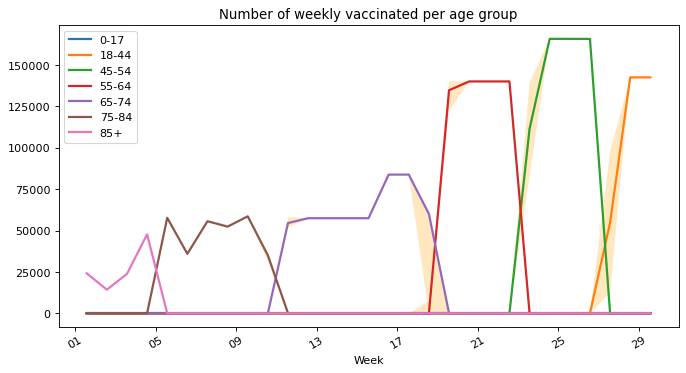

In [8]:
vaccinated_age_groups = np.sum(vaccinated, axis=2)
tot_vaccinated_age_groups = np.sum(vaccinated_age_groups, axis=2)
# Calculate quantiles and mean
percentile_limit = 90

# Plot data # vaccines
labels = ['0-17', '18-44', '45-54', '55-64', '65-74', '75-84', '85+']
plot_only_2021 = True
dates = [mdp_paths[0][week].date for week in range(1, len(mdp_paths[0]))]
num_weeks_from_first_sim_to_2021 = 45

if plot_only_2021:
    dates = [mdp_paths[0][week].date for week in range(len(mdp_paths[0])) if mdp_paths[0][week].date > datetime.date(2021, 1, 4)]
    vaccinated_age_groups = vaccinated_age_groups[:,num_weeks_from_first_sim_to_2021:,:]

limits = get_percentiles(vaccinated_age_groups, percentile_limit, 0)
plot_weekly_vaccination_per_age_group(limits, dates, labels)

No handles with labels found to put in legend.


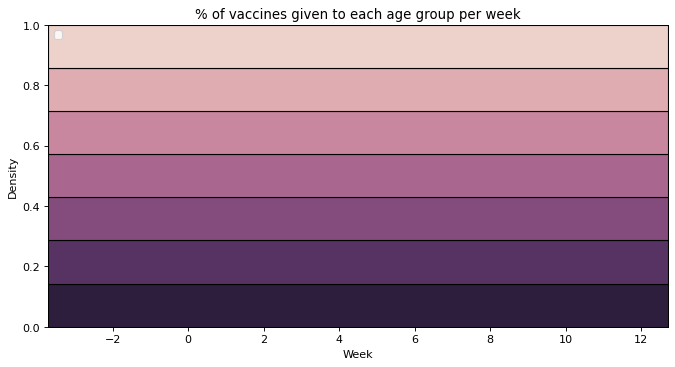

In [9]:
# METHOD 1
# Clean data for plotting
fraction_vaccinated_age_groups = vaccinated_age_groups/vaccinated_age_groups.sum(axis=2, keepdims=1)
fraction_vaccinated_age_groups_mean = np.mean(fraction_vaccinated_age_groups, axis=1)
df_vaccinated = pd.DataFrame(fraction_vaccinated_age_groups_mean, columns=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
df_vaccinated['week'] = df_vaccinated.index
df_vaccinated_long = pd.wide_to_long(df_vaccinated, ["A"], i="week", j="agegroup")
df_vaccinated_long = df_vaccinated_long.reset_index(level=[0,1]).rename(columns={'A': 'percentage'})

# plot 
plot_weekly_percentage_of_vaccination_per_age_group(df_vaccinated_long)

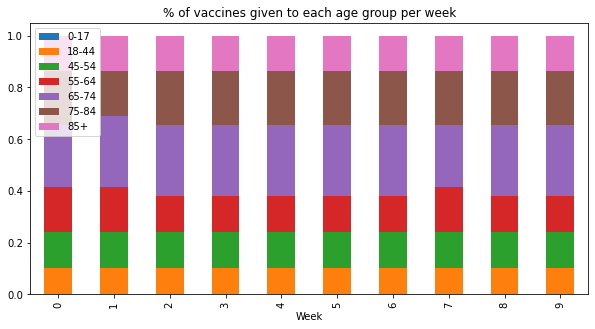

In [10]:
# METHOD 2
# Clean data for plotting
fraction_vaccinated_age_groups = vaccinated_age_groups/vaccinated_age_groups.sum(axis=2, keepdims=1)
fraction_vaccinated_age_groups_mean = np.mean(fraction_vaccinated_age_groups, axis=1)
df_vaccinated = pd.DataFrame(fraction_vaccinated_age_groups_mean, columns=labels)

# Plot
plot_weekly_percentage_of_vaccination_per_age_group_2(df_vaccinated)


## Vaccinated per region

In [11]:
vaccinated_regions = np.sum(vaccinated, axis=1)
vaccinated_regions.shape

(10, 356, 7)

# Infection and Deaths

### Read data from Norway

In [12]:
data_daily = pd.read_csv("../data/fhi_data_daily.csv")
# data_daily = data_daily[data_daily.year.astype(int) < 2021].reset_index() uncomment if only plotting data fro 2021 
data_daily = data_daily[['date', 'I_new', 'I_cumulative', 'D_new', 'D_cumulative']]
data_daily.date = data_daily['date'].apply(lambda x: 
                                        x.split("/")[1].zfill(2) + "/"
                                        + x.split("/")[0].zfill(2) + "/"
                                        + x.split("/")[2].zfill(2))
data_daily.head()

,date,I_new,I_cumulative,D_new,D_cumulative
0,21/02/2020,1.0,1.0,0.0,0.0
1,22/02/2020,0.0,1.0,0.0,0.0
2,23/02/2020,0.0,1.0,0.0,0.0
3,24/02/2020,0.0,1.0,0.0,0.0
4,25/02/2020,0.0,1.0,0.0,0.0


### Find cumulative cases of deaths and infected from model

In [13]:
dir_path = "../"
relative_path = "results/10_simulations_susceptible_based_2021_05_29_11_17_29"
path = dir_path + relative_path
mdp_paths_path   =   f"{path}/mdp_paths.pkl"
mdp_reffs_path   =   f"{path}/mdp_reffs.pkl"
start_date_population_age_labels_path = f"{path}/start_date_population_age_labels.pkl"
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', paths.config)
start_date, population, age_labels = utils.read_pickle(start_date_population_age_labels_path)
mdp_paths = utils.read_pickle(mdp_paths_path)
R_effs = utils.read_pickle(mdp_reffs_path)
mdp_path = mdp_paths[-1]
R_eff = R_effs[-1]

# Retrive data
dates = []
num_simulations = len(mdp_paths)
num_simulation_weeks = len(mdp_paths[0])
final_deaths = np.zeros((num_simulations, num_simulation_weeks))
final_infected = np.zeros((num_simulations, num_simulation_weeks))

for i in range(num_simulations):
    for j in range(num_simulation_weeks):
        if i == 0:
            dates.append(mdp_paths[i][j].date)
        final_deaths[i][j] = np.sum(mdp_paths[i][j].new_deaths)
        final_infected[i][j] = np.sum(mdp_paths[i][j].new_infected)

In [14]:
percentile_limit=90

deaths_cumulative = final_deaths.cumsum(axis=1)
deaths_mean = final_deaths.mean(axis=0)
deaths_mean_cumulative = deaths_cumulative.mean(axis=0)
u_percentile_deaths = np.percentile(final_deaths, percentile_limit, axis=0)
l_percentile_deaths = np.percentile(final_deaths, 100-percentile_limit, axis=0)
u_percentile_deaths_cum = np.percentile(deaths_cumulative, percentile_limit, axis=0)
l_percentile_deaths_cum = np.percentile(deaths_cumulative, 100-percentile_limit, axis=0)

infected_cumulative = final_infected.cumsum(axis=1)
infected_mean = final_infected.mean(axis=0)
infected_mean_cumulative = infected_cumulative.mean(axis=0)
u_percentile_infected = np.percentile(final_infected, percentile_limit, axis=0)
l_percentile_infected = np.percentile(final_infected, 100-percentile_limit, axis=0)
u_percentile_infected_cum = np.percentile(infected_cumulative, percentile_limit, axis=0)
l_percentile_infected_cum = np.percentile(infected_cumulative, 100-percentile_limit, axis=0)

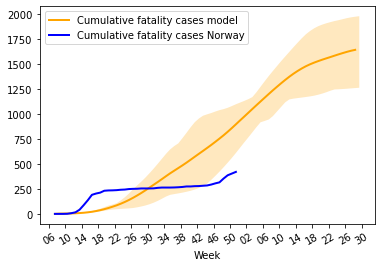

In [15]:
restrict_to_real_data_length = False
max_weeks_real_data = 45

fig, ax = plt.subplots(1)
#ax.plot(dates, deaths_mean, lw=2, label='Deaths model', color='blue')

if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], deaths_mean_cumulative[:max_weeks_real_data], lw=2, label='Cumulative fatality cases model', color='orange')
    ax.plot(dates[:max_weeks_real_data], data_daily.D_cumulative.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color='blue')
    #ax.fill_between(dates, u_percentile_deaths, l_percentile_deaths, facecolor='blue', alpha=.25)
    ax.fill_between(dates[:max_weeks_real_data], u_percentile_deaths_cum[:max_weeks_real_data], l_percentile_deaths_cum[:max_weeks_real_data], facecolor='orange', alpha=0.25)

else:
    ax.plot(dates[:-1], deaths_mean_cumulative[:-1], lw=2, label='Cumulative fatality cases model', color='orange')
    ax.plot(dates[:max_weeks_real_data], data_daily.D_cumulative.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color='blue')
    #ax.fill_between(dates, u_percentile_deaths, l_percentile_deaths, facecolor='blue', alpha=0.25)
    ax.fill_between(dates, u_percentile_deaths_cum, l_percentile_deaths_cum, facecolor='orange', alpha=0.25)

#ax.set_title(r'Cumulative and new deaths per week')
ax.legend(loc='upper left')

# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%U')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=28)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation = 30)
ax.set_xlabel("Week")

fig.savefig("../plots/computational_study/deaths_comparison.png", bbox_inches='tight', dpi=150)

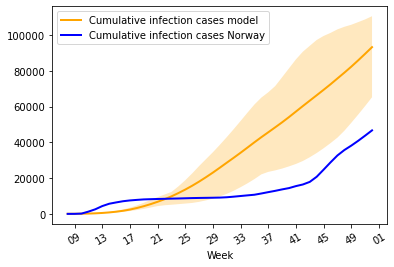

In [16]:
restrict_to_real_data_length = True
max_weeks_real_data = 45

fig, ax = plt.subplots(1)
#ax.plot(dates, deaths_mean, lw=2, label='Deaths model', color='blue')
if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], infected_mean_cumulative[:max_weeks_real_data], lw=2, label='Cumulative infection cases model', color='orange')
    ax.plot(dates[:max_weeks_real_data], data_daily.I_cumulative.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color='blue')
    ax.fill_between(dates[:max_weeks_real_data], u_percentile_infected_cum[:max_weeks_real_data], l_percentile_infected_cum[:max_weeks_real_data], facecolor='orange', alpha=0.25)
else:
    ax.plot(dates[:-1], infected_mean_cumulative[:-1], lw=2, label='Cumulative infection cases model', color='orange')
    ax.plot(dates[:max_weeks_real_data], data_daily.I_cumulative.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color='blue')
    #ax.fill_between(dates, u_percentile_deaths, l_percentile_deaths, facecolor='blue', alpha=0.25)
    ax.fill_between(dates, u_percentile_infected_cum, l_percentile_infected_cum, facecolor='orange', alpha=0.25)

#ax.set_title(r'Cumulative and new infected per week')
ax.legend(loc='upper left')

# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%U')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=28)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation = 30) 
ax.set_xlabel("Week")

fig.savefig("../plots/computational_study/infected_comparison.png", bbox_inches='tight', dpi=150)